In [8]:
# Standard imports
import os
import re
import pickle
import sys
import time
from glob import glob
from math import ceil
from urllib import request
from zipfile import ZipFile
import tarfile

# Third-party imports
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import tensorflow as tf
import imageio
import cv2
from skimage import transform


# Install tqdm
!pip install tqdm
from tqdm import tqdm

print('Python', sys.version)
print('Numpy', np.__version__)
print('Tensorflow', tf.__version__)

A4_PORTRAIT = (8.27, 11.69)
A4_LANDSCAPE = A4_PORTRAIT[::-1]

IMAGE_ROAD_TOP = 275
IMAGE_ROAD_BOTTOM = 525
IMAGE_BOTTOM_HOOD = 490


PIXEL_ROAD = 7
PIXEL_CAR = 10
PIXEL_MAX = 255



# Download Lyft challenge training data
data_url='https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/Lyft_Challenge/Training+Data/lyft_training_data.tar.gz'
    
zip_fn = '../lyft_data/lyft_training_data.tar.gz'
dest = '../lyft_data/'
if not os.path.exists(dest+'Train'):
    print("entering")
    if not os.path.exists(zip_fn): #Expecting the zip file at ../lyft_data location
        request.urlretrieve(data_url, zip_fn)
    if (zip_fn.endswith("tar.gz")):    
        tar = tarfile.open(zip_fn, "r:gz")
        tar.extractall(dest)
        tar.close()
    elif (zip_fn.endswith("tar")):    
        tar = tarfile.open(zip_fn, "r:")
        tar.extractall(dest)
        tar.close()
        

# Download pretrained VGG16
vgg_url = 'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/vgg.zip'
vgg_fn = '../lyft_data/vgg16.zip'
vgg_path = '../lyft_data/'
if not os.path.exists(vgg_path+'vgg'):
    print("etering")
    if not os.path.exists(vgg_fn): #Expecting the zip file vgg16.zip at ../lyft_data
        request.urlretrieve(vgg_url, vgg_fn)
    
    vgg_zip = ZipFile(vgg_fn)
    vgg_zip.extractall(vgg_path)

print("End")

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Python 3.5.2 | packaged by conda-forge | (default, Jan 20 2017, 20:58:31) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.54)]
Numpy 1.14.3
Tensorflow 1.8.0
End


In [9]:
# Matplotlib configuration
%matplotlib inline

In [2]:
def augment_brightness_camera_images(image):
  # Randomly increase or decrease brightness, not used
  image = colors.rgb_to_hsv(image).astype(float)
  random_bright = .5 + np.random.uniform()
  image[:, :, 2] = image[:, :, 2] * random_bright
  image[:, :, 2][image[:, :, 2] > PIXEL_MAX] = PIXEL_MAX
  image = colors.hsv_to_rgb(image).astype(int)
  return image

def rotate(image, label, angle):
  # Rotate by given angle
  angle = np.random.random() * angle * 2 - angle
  image = scipy.misc.imrotate(image, angle)
  label = scipy.misc.imrotate(label, angle)
  return image, label

def flip(image, label):
  # Flip images horizontally
  image = image[:, ::-1, :]
  label = label[:, ::-1, :]
  return image, label

def randomize(image, label):
  # Randomize a single image
  image = augment_brightness_camera_images(image)
  image, label = rotate(image, label, angle=5)
  if np.random.random() < .5:
    image, label = flip(image, label)
  return image, label


def gen_batch(feature_img_paths, image_shape, subject, augment=False):
  # Returns a batch generator for given images

  def get_batches(batch_size, shuffle=False):
    #feature_img_paths = glob(os.path.join(data_dir, 'CameraRGB', '*.png'))
    if shuffle:
      np.random.shuffle(feature_img_paths)
    foreground_road = np.array([PIXEL_ROAD, 0, 0])
    foreground_car = np.array([PIXEL_CAR, 0, 0])
    for i in range(0, len(feature_img_paths), batch_size):
      features, labels = [], []
      for fn in feature_img_paths[i:i + batch_size]:
        # Preprocess features
        feature = imageio.imread(fn)
        #feature = scipy.misc.imread(fn)
        
        if subject=='road':
            feature = feature[IMAGE_ROAD_TOP:IMAGE_ROAD_BOTTOM,:,:]
        feature = scipy.misc.imresize(feature, image_shape) # If scipy is used, image_shape = (160, 576)
        #feature = cv2.resize(feature, image_shape) # If cv2 is used, image_shape = (576, 160)
        #feature = transform.resize(feature, image_shape)
        
        
        # Load labels
        label = imageio.imread(fn.replace('CameraRGB', 'CameraSeg'))
        #label = scipy.misc.imread(fn.replace('CameraRGB', 'CameraSeg'))
        
        #***************************************************************
        ##The following steps marks the HOOD pixels as Other(0)
        a = label[IMAGE_BOTTOM_HOOD:,:,:]==10
        b=np.copy(label[IMAGE_BOTTOM_HOOD:,:,:])
        b[a]=0
        label=np.concatenate((label[:IMAGE_BOTTOM_HOOD,:,:],b),axis=0)
        #***************************************************************
        
        #***************************************************************
        #The following step marks the lane marks as roads
        label[label==6]=7
        #***************************************************************
        
        if subject=='road':
            label = label[IMAGE_ROAD_TOP:IMAGE_ROAD_BOTTOM,:,:]
        label = scipy.misc.imresize(label, image_shape)
        #label = cv2.resize(label, image_shape)
        
        if augment:
          feature, label = randomize(feature, label)

        # Convert label image to output array
        if subject == 'road':
            gt_fg_road = np.all(label == foreground_road, axis=2)
            gt_fg_road = gt_fg_road.reshape(*gt_fg_road.shape, 1)
            label = np.concatenate((gt_fg_road, np.invert(gt_fg_road)), axis=2)
        elif subject == 'car':
            gt_fg_car = np.all(label == foreground_car, axis=2)
            gt_fg_car = gt_fg_car.reshape(*gt_fg_car.shape, 1)
            label = np.concatenate((gt_fg_car, np.invert(gt_fg_car)), axis=2)
        elif subject == 'all':
            gt_fg_road = np.all(label == foreground_road, axis=2)
            gt_fg_car = np.all(label == foreground_car, axis=2)
            gt_road_and_car = gt_fg_road | gt_fg_car
            
            
            gt_fg_road = gt_fg_road.reshape(*gt_fg_road.shape, 1)
            gt_fg_car = gt_fg_car.reshape(*gt_fg_car.shape, 1)
            gt_road_and_car = gt_road_and_car.reshape(*gt_road_and_car.shape, 1)
            
            
            label = np.concatenate((gt_fg_road,gt_fg_car,np.invert(gt_road_and_car)), axis=2)
        else:
            print("Error. In evaluating subject")
            gt_fg_car=[]
            gt_fg_road=[]
            label=[]
        
        features.append(feature)
        labels.append(label)
      yield np.array(features), np.array(labels)

  return get_batches

In [11]:
data_dir = '../lyft_data/Train'

image_shape = (160, 576)
#image_shape = (576, 160)

In [6]:
##To check how many images have road pixels above 275 and below 525
filenames_test_test = glob(os.path.join(data_dir, 'CameraSeg', '*.png'))
print(len(filenames_test_test))
print("Top:")
print(IMAGE_ROAD_TOP)
print("Bottom:")
print(IMAGE_ROAD_BOTTOM)
for fn1 in filenames_test_test:
    labels_test = imageio.imread(fn1)
    if np.count_nonzero(labels_test[:IMAGE_ROAD_TOP,:,:]==7)>0:
        print("one more top side")
    if np.count_nonzero(labels_test[IMAGE_ROAD_BOTTOM:,:,:]==7)>0:
        print("one more bottom side")
print("Done")


1000
Top:
275
Bottom:
525
Done


/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:74: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(50, 160, 576, 3)
uint8
(50, 160, 576, 3)
bool


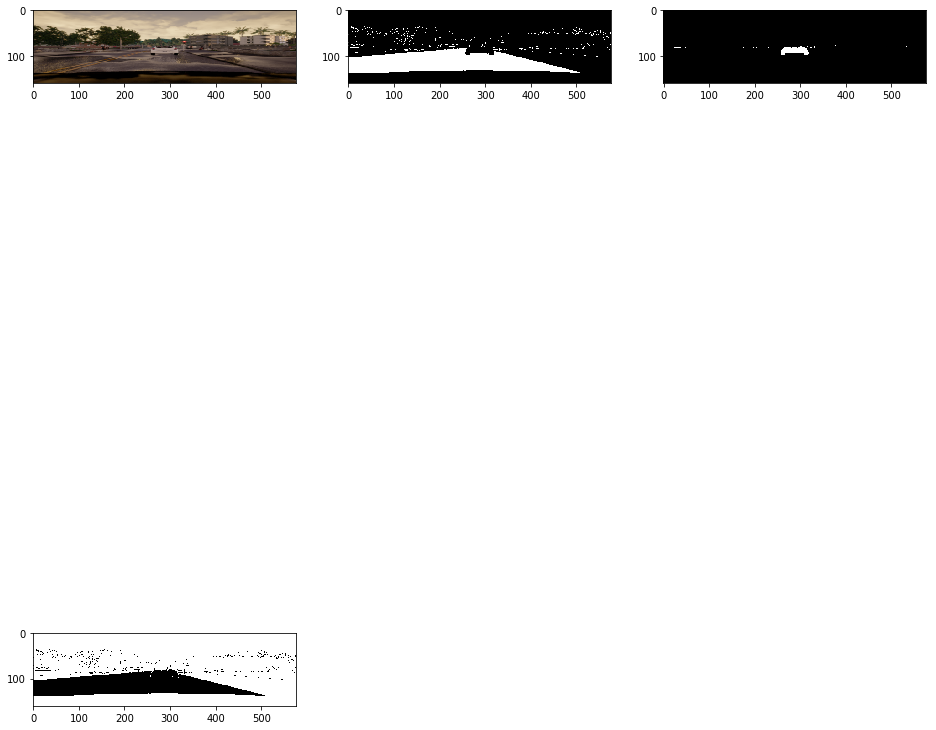

In [12]:
##Just to check.To check the batch functions. Do not run if not required
sub='all'
filenames_test = glob(os.path.join(data_dir, 'CameraRGB', '*.png'))
get_batches_fn = gen_batch(
          feature_img_paths=filenames_test,
          image_shape=image_shape,
          subject = sub,
          augment=False)
images, labels =next(get_batches_fn(50, shuffle=False))
#a=labels[0][:,:,2]

if sub == 'all':
    
    #plt.imshow(labels[0],cmap='gray')
    fig = plt.figure(figsize=(16,21))
    plt.subplot(231)
    #plt.imshow(images[49][:,:,0],cmap='gray')
    plt.imshow(images[20])
    #print(np.amax(images[49]))

    plt.subplot(232)
    plt.imshow(labels[20][:,:,0],cmap='gray')
    
    plt.subplot(233)
    plt.imshow(labels[20][:,:,1],cmap='gray')
    
    plt.subplot(234)
    plt.imshow(labels[20][:,:,2],cmap='gray')
    
    for k,label in enumerate(labels):
        total = label[:,:,0] | label[:,:,1] | label[:,:,2]
        bb= np.size(total) - np.count_nonzero(total)
        if bb > 0:
            print("Here is an issue")
            print(k)
            
        add_t = np.zeros_like(label[:,:,0])
        add1 = np.add(label[:,:,0],label[:,:,1] )
        add2 = np.add(add1,label[:,:,2] )
        add_t[add2>1]=1
        bb1= np.count_nonzero(add_t)
        if bb1 > 0:
            print("Here is another issue")
            print(k)
            
    '''
    f, ax = plt.subplots(nrows=2, ncols=3)
    f.set_size_inches(16, 21)
    ax[0, 0].imshow(images[25])
    ax[1, 0].imshow(labels[25][:,:,0],cmap='gray')
    ax[1, 1].imshow(labels[25][:,:,1],cmap='gray')
    ax[1, 2].imshow(labels[25][:,:,2],cmap='gray')
    '''
else:
    #plt.imshow(labels[0],cmap='gray')
    fig = plt.figure()
    plt.subplot(121)
    #plt.imshow(images[49][:,:,0],cmap='gray')
    plt.imshow(images[20])
    #print(np.amax(images[49]))

    plt.subplot(122)
    plt.imshow(labels[20][:,:,1],cmap='gray')

print(np.shape(images))
print(images.dtype)
print(np.shape(labels))
print(labels.dtype)


In [16]:
#Load VGG-16 model and build FCN

num_classes = 3 #for subject 'all' 

# Load saved model
vgg_tag = 'vgg16'

with tf.Session() as sess:
  tf.saved_model.loader.load(sess, [vgg_tag], vgg_path + 'vgg')

# Gather required tensor references
vgg_input_tensor_name = 'image_input:0'
vgg_keep_prob_tensor_name = 'keep_prob:0'
vgg_layer3_out_tensor_name = 'layer3_out:0'
vgg_layer4_out_tensor_name = 'layer4_out:0'
vgg_layer7_out_tensor_name = 'layer7_out:0'

graph = tf.get_default_graph()
input_image = graph.get_tensor_by_name(vgg_input_tensor_name)
keep_prob = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
vgg_layer3_out = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
vgg_layer4_out = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
vgg_layer7_out = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)

# Regularizers and initializers
# initializer = lambda: tf.contrib.layers.xavier_initializer()
initializer = lambda: tf.truncated_normal_initializer(stddev=0.01)
regularizer = lambda: tf.contrib.layers.l2_regularizer(1e-5)

# 1x1 convolution
layer7_out = tf.layers.conv2d(
    inputs=vgg_layer7_out,
    filters=num_classes,
    kernel_size=1,
    padding='same',
    kernel_regularizer=regularizer(),
    kernel_initializer=initializer())

# Upsample
layer7_up = tf.layers.conv2d_transpose(
    inputs=layer7_out,
    filters=num_classes,
    kernel_size=4,
    strides=(2, 2),
    padding='same',
    kernel_regularizer=regularizer(),
    kernel_initializer=initializer())

# 1x1 convolution
layer4_out = tf.layers.conv2d(
    inputs=vgg_layer4_out,
    filters=num_classes,
    kernel_size=1,
    padding='same',
    kernel_regularizer=regularizer(),
    kernel_initializer=initializer())

# Skip layer
skip_1 = tf.add(layer7_up, layer4_out)

# Upsample
skip_1_up = tf.layers.conv2d_transpose(
    inputs=skip_1,
    filters=num_classes,
    kernel_size=4,
    strides=(2, 2),
    padding='same',
    kernel_regularizer=regularizer(),
    kernel_initializer=initializer())

# 1x1 convolution
layer3_out = tf.layers.conv2d(
    inputs=vgg_layer3_out,
    filters=num_classes,
    kernel_size=1,
    padding='same',
    kernel_regularizer=regularizer(),
    kernel_initializer=initializer())

# Skip layer
skip_2 = tf.add(skip_1_up, layer3_out)

# Upsampled final
nn_last_layer = tf.layers.conv2d_transpose(
    inputs=skip_2,
    filters=num_classes,
    kernel_size=16,
    strides=(8, 8),
    padding='same',
    kernel_regularizer=regularizer(),
    kernel_initializer=initializer())

print("Done")

INFO:tensorflow:Restoring parameters from b'../lyft_data/vgg\\variables\\variables'
Done


In [17]:
#Define Training operations
correct_label = tf.placeholder(tf.int32, [None, None, None, num_classes], name = 'correct_label')
learning_rate = tf.placeholder(tf.float32)
logits = tf.reshape(nn_last_layer, (-1, num_classes))
predicts = tf.nn.softmax(logits, name='predicts')
truth = tf.reshape(correct_label, (-1, num_classes))
global_step = tf.Variable(0, name='global_step', trainable=False)

# Cross-entropy operation
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=truth)
cross_entropy_loss = tf.reduce_mean(cross_entropy, name='loss')
tf.summary.scalar('cross_entropy_loss', cross_entropy_loss)

# Regularization loss
l2_loss = tf.losses.get_regularization_loss()
#l2_loss = tf.losses.get_regularization_losses()
tf.summary.scalar('l2_loss', l2_loss)
total_loss = cross_entropy_loss + l2_loss
#total_loss = cross_entropy_loss 
tf.summary.scalar('total_loss', total_loss)
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(total_loss, global_step)

# Merge summary operation
merged = tf.summary.merge_all()
print("Done")

Done


In [18]:
#Perform training if no saved model is available

# Hyperparameters
augment_training = True
batch_size = 8
epochs = 50
min_epochs = 15
patience = 3
random_seed = 42
starting_learning_rate = 1e-4


# Training configuration
saver = tf.train.Saver()

with tf.Session() as sess:
    writer = tf.summary.FileWriter('tensorboard')  # , sess.graph) Disable graph
    print("here")
    sess.run(tf.global_variables_initializer())
    print("here1")
    # Path to vgg model
    #vgg_path = os.path.join('models', 'vgg')'../lyft_data/'

    # Prepare training and test datasets
    filenames = glob(os.path.join(data_dir, 'CameraRGB', '*.png'))
    print('Dataset contains', len(filenames), 'examples.')
    np.random.seed(random_seed)  # Make it reproduceable
    np.random.shuffle(filenames)
    training = int(len(filenames) * .90)  # 85% for training, 15% for testing
    training, testing = filenames[:training], filenames[training:]
    
    pickle.dump(testing, open('testing_data_pickle_both.p',"wb"))
    print("Test data saved in pickle")

    # Check a saved model exists or train a new one
    if os.path.exists('./model_combined.ckpt.meta'):
      # assert False  # Force training a new model
      #assert os.path.exists('./model.ckpt.meta')
        print("model already exists")
    else:
      # Train new model
      print('Training on', len(training), 'samples.')
      get_batches_fn = gen_batch(
          feature_img_paths=training,
          image_shape=image_shape,
          subject='all',
          augment=augment_training)

      # Continue training while the loss improves
      best_loss = 1e9
      failure = 0
      for e in range(epochs):
        epoch_loss = 0
        num_images = 0
        sys.stdout.flush()
        for images, labels in tqdm(get_batches_fn(batch_size, shuffle=True),
                                   desc='Training epoch {}'.format(e + 1),
                                   total=ceil(len(training) / batch_size)):
            #print(labels.dtype)
            
            summary, step, _, loss = sess.run([
              merged,
              global_step,
              train_op,
              cross_entropy_loss], feed_dict={
                  input_image: images,
                  correct_label: labels,
                  keep_prob: 0.75,
                  learning_rate: starting_learning_rate})
            writer.add_summary(summary, step)
            epoch_loss += loss * len(images)
            
            num_images += len(images)

        epoch_loss /= num_images
        sys.stderr.flush()
        print('Epoch {} loss: {:.3f}'.format(e + 1, epoch_loss))
        print(num_images)
        if e >= min_epochs and epoch_loss > best_loss:
          if failure == patience:
            break
          failure += 1
        else:
            failure = 0
            best_loss = epoch_loss
            print('Saving model')
            saver.save(sess, './model_combined.ckpt')
print("Training Done")

here
here1
Dataset contains 1000 examples.
Training on 900 samples.


Training epoch 1:   0%|                                | 0/113 [00:00<?, ?it/s]d:\users\F65318A\AppData\Local\Continuum\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
d:\users\F65318A\AppData\Local\Continuum\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:74: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
d:\users\F65318A\AppData\Local\Continuum\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imrotate` is deprecated!
`imrotate` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.rotate`` instead.
  del sys.path[0]
d:\users\F65318A\AppData\Local\Continuum\Anaconda3\envs\carnd-term1\lib\site-packages\ipyk

Epoch 1 loss: 0.000
900
Saving model


Training epoch 2: 100%|██████████████████████| 113/113 [08:04<00:00,  1.12s/it]


Epoch 2 loss: 0.000
900
Saving model


Training epoch 3: 100%|██████████████████████| 113/113 [04:59<00:00,  1.09it/s]


Epoch 3 loss: 0.000
900
Saving model


Training epoch 4: 100%|██████████████████████| 113/113 [02:42<00:00,  1.01it/s]


Epoch 4 loss: 0.000
900
Saving model


Training epoch 5:  64%|██████████████▋        | 72/113 [07:18<03:56,  5.78s/it]

KeyboardInterrupt: 

#### The next two cells only if to test and did not train the model from the beginning or skip next

In [1]:
import pickle
import numpy as np
import tensorflow as tf
import sys

# Third-party imports
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import scipy.misc

import imageio
import cv2

from tqdm import tqdm

IMAGE_ROAD_TOP = 275
IMAGE_ROAD_BOTTOM = 525
IMAGE_BOTTOM_HOOD = 490


PIXEL_ROAD = 7
PIXEL_CAR = 10
PIXEL_MAX = 255

/anaconda/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
image_shape = (160, 576)

#loading testing data
testing = pickle.load( open("testing_data_pickle_both.p", "rb" ) )
loaded_graph = tf.Graph()
load_dir = './model_combined.ckpt'

#Run the gen_batch cell above

with tf.Session(graph=loaded_graph) as sess:
    #Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)
    
    # Gather required tensor references
    input_image = loaded_graph.get_tensor_by_name('image_input:0')
    correct_label = loaded_graph.get_tensor_by_name('correct_label:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    predicted = loaded_graph.get_tensor_by_name('predicts:0')
    cross_entropy_loss = loaded_graph.get_tensor_by_name('loss:0')
    
    
    print('Testing on {} samples.'.format(len(testing)))
    results, losses = [], []
    sys.stdout.flush()
    for images, labels in tqdm(gen_batch(testing, image_shape,subject='all')(1),
                             desc='Evaluating testing dataset',
                             total=len(testing)):
        print(np.shape(images))
        result, loss = sess.run([predicted, cross_entropy_loss], feed_dict={
        input_image: images,
        correct_label: labels,
        keep_prob: 1.0})
        
        print(np.shape(result))
        
        predic = (result[:, 1] > .5).reshape((-1, ))
        actual = (labels[:, :, :, 1] > .5).reshape((-1, ))
    
        inter = predic * actual  # Element-wise multiplication of 0 and 1
        union = np.zeros_like(predic)
        union[predic == 1] = 1
        union[actual == 1] = 1
        results.append([images, predic, actual, np.sum(inter) / np.sum(union)])
        losses.append(loss)
    sys.stderr.flush()
    results = sorted(results, key=lambda r: r[3], reverse=True)
    print('Average IOU', np.average([r[3] for r in results]))
    print('Testing loss:', np.average(losses))

INFO:tensorflow:Restoring parameters from ./model_combined.ckpt
Testing on 100 samples.


Evaluating testing dataset:   0%|          | 0/100 [00:00<?, ?it/s]/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:74: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(1, 160, 576, 3)


Evaluating testing dataset:   1%|          | 1/100 [00:21<35:04, 21.26s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:   2%|▏         | 2/100 [00:25<26:23, 16.16s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:   3%|▎         | 3/100 [00:29<20:13, 12.51s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:   4%|▍         | 4/100 [00:34<16:12, 10.13s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:   5%|▌         | 5/100 [00:37<12:50,  8.11s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:   6%|▌         | 6/100 [00:40<10:13,  6.52s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:   7%|▋         | 7/100 [00:43<08:26,  5.45s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:   8%|▊         | 8/100 [00:46<07:11,  4.68s/it]

(92160, 3)
(1, 160, 576, 3)


/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in long_scalars
Evaluating testing dataset:   9%|▉         | 9/100 [00:48<06:00,  3.96s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  10%|█         | 10/100 [00:50<05:16,  3.52s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  11%|█         | 11/100 [00:53<04:51,  3.28s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  12%|█▏        | 12/100 [00:56<04:40,  3.19s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  13%|█▎        | 13/100 [00:59<04:28,  3.08s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  14%|█▍        | 14/100 [01:02<04:13,  2.95s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  15%|█▌        | 15/100 [01:04<04:01,  2.84s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  16%|█▌        | 16/100 [01:06<03:45,  2.69s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  17%|█▋        | 17/100 [01:09<03:43,  2.69s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  18%|█▊        | 18/100 [01:11<03:21,  2.46s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  19%|█▉        | 19/100 [01:14<03:21,  2.48s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  20%|██        | 20/100 [01:17<03:36,  2.71s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  21%|██        | 21/100 [01:22<04:23,  3.33s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  22%|██▏       | 22/100 [01:25<04:25,  3.40s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  23%|██▎       | 23/100 [01:28<03:58,  3.10s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  24%|██▍       | 24/100 [01:30<03:44,  2.95s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  25%|██▌       | 25/100 [01:33<03:32,  2.83s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  26%|██▌       | 26/100 [01:36<03:28,  2.81s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  27%|██▋       | 27/100 [01:38<03:12,  2.64s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  28%|██▊       | 28/100 [01:40<03:01,  2.52s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  29%|██▉       | 29/100 [01:43<02:59,  2.53s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  30%|███       | 30/100 [01:45<02:58,  2.55s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  31%|███       | 31/100 [01:48<02:53,  2.52s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  32%|███▏      | 32/100 [01:50<02:46,  2.44s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  33%|███▎      | 33/100 [01:52<02:39,  2.38s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  34%|███▍      | 34/100 [01:55<02:40,  2.43s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  35%|███▌      | 35/100 [01:57<02:41,  2.48s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  36%|███▌      | 36/100 [01:59<02:32,  2.38s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  37%|███▋      | 37/100 [02:03<02:45,  2.62s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  38%|███▊      | 38/100 [02:05<02:34,  2.49s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  39%|███▉      | 39/100 [02:07<02:20,  2.30s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  40%|████      | 40/100 [02:09<02:11,  2.18s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  41%|████      | 41/100 [02:10<02:03,  2.10s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  42%|████▏     | 42/100 [02:12<01:57,  2.02s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  43%|████▎     | 43/100 [02:14<01:52,  1.96s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  44%|████▍     | 44/100 [02:16<01:44,  1.87s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  45%|████▌     | 45/100 [02:17<01:39,  1.81s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  46%|████▌     | 46/100 [02:19<01:35,  1.77s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  47%|████▋     | 47/100 [02:21<01:32,  1.75s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  48%|████▊     | 48/100 [02:23<01:29,  1.73s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  49%|████▉     | 49/100 [02:25<01:33,  1.83s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  50%|█████     | 50/100 [02:27<01:42,  2.06s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  51%|█████     | 51/100 [02:29<01:43,  2.12s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  52%|█████▏    | 52/100 [02:33<02:07,  2.65s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  53%|█████▎    | 53/100 [02:36<02:01,  2.59s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  54%|█████▍    | 54/100 [02:38<01:53,  2.46s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  55%|█████▌    | 55/100 [02:40<01:45,  2.35s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  56%|█████▌    | 56/100 [02:42<01:40,  2.28s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  57%|█████▋    | 57/100 [02:44<01:34,  2.20s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  58%|█████▊    | 58/100 [02:47<01:36,  2.30s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  59%|█████▉    | 59/100 [02:49<01:32,  2.26s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  60%|██████    | 60/100 [02:52<01:34,  2.37s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  61%|██████    | 61/100 [02:54<01:31,  2.34s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  62%|██████▏   | 62/100 [02:56<01:32,  2.44s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  63%|██████▎   | 63/100 [02:59<01:26,  2.33s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  64%|██████▍   | 64/100 [03:01<01:23,  2.31s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  65%|██████▌   | 65/100 [03:03<01:21,  2.32s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  66%|██████▌   | 66/100 [03:06<01:21,  2.40s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  67%|██████▋   | 67/100 [03:08<01:14,  2.25s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  68%|██████▊   | 68/100 [03:10<01:08,  2.14s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  69%|██████▉   | 69/100 [03:11<01:04,  2.08s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  70%|███████   | 70/100 [03:14<01:02,  2.08s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  71%|███████   | 71/100 [03:16<01:00,  2.08s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  72%|███████▏  | 72/100 [03:18<00:57,  2.04s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  73%|███████▎  | 73/100 [03:20<00:55,  2.06s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  74%|███████▍  | 74/100 [03:22<00:55,  2.12s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  75%|███████▌  | 75/100 [03:24<00:52,  2.10s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  76%|███████▌  | 76/100 [03:26<00:50,  2.10s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  77%|███████▋  | 77/100 [03:28<00:48,  2.13s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  78%|███████▊  | 78/100 [03:31<00:47,  2.16s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  79%|███████▉  | 79/100 [03:32<00:44,  2.11s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  80%|████████  | 80/100 [03:34<00:41,  2.07s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  81%|████████  | 81/100 [03:37<00:42,  2.23s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  82%|████████▏ | 82/100 [03:39<00:40,  2.25s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  83%|████████▎ | 83/100 [03:42<00:38,  2.25s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  84%|████████▍ | 84/100 [03:44<00:36,  2.30s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  85%|████████▌ | 85/100 [03:46<00:33,  2.24s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  86%|████████▌ | 86/100 [03:48<00:28,  2.03s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  87%|████████▋ | 87/100 [03:49<00:24,  1.87s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  88%|████████▊ | 88/100 [03:51<00:21,  1.80s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  89%|████████▉ | 89/100 [03:52<00:18,  1.72s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  90%|█████████ | 90/100 [03:54<00:17,  1.74s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  91%|█████████ | 91/100 [03:56<00:15,  1.75s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  92%|█████████▏| 92/100 [03:58<00:13,  1.72s/it]

(92160, 3)
(1, 160, 576, 3)


Evaluating testing dataset:  93%|█████████▎| 93/100 [03:59<00:11,  1.69s/it]

(92160, 3)
(1, 160, 576, 3)


KeyboardInterrupt: 

#### Use this cell to test as a continuation of training

In [5]:
## Evaluate model performance on test dataset
with tf.Session() as sess:
  # Reload the best model found
  print('Reloading best model')
  saver.restore(sess, './model_combined.ckpt')

  # Evaluate
  print('Testing on {} samples.'.format(len(testing)))
  results, losses = [], []
  sys.stdout.flush()
  for images, labels in tqdm(gen_batch(testing, image_shape,subject='all')(1),
                             desc='Evaluating testing dataset',
                             total=len(testing)):
    result, loss = sess.run([tf.nn.softmax(logits), cross_entropy_loss], feed_dict={
        input_image: images,
        correct_label: labels,
        keep_prob: 1.0})
    predic = (result[:, 0] > .5).reshape((-1, ))
    actual = (labels[:, :, :, 0] > .5).reshape((-1, ))
    
    inter = predic * actual  # Element-wise multiplication of 0 and 1
    union = np.zeros_like(predic)
    union[predic == 1] = 1
    union[actual == 1] = 1
    results.append([images, predic, actual, np.sum(inter) / np.sum(union)])
    losses.append(loss)

sys.stderr.flush()
results = sorted(results, key=lambda r: r[3], reverse=True)
print('Average IOU', np.average([r[3] for r in results]))
print('Testing loss:', np.average(losses))

Reloading best model


NameError: name 'saver' is not defined

[[204.   0.   0.]]
[[204.   0.   0.]]
[[204.   0.   0.]]
[[204.   0.   0.]]
[[204.   0.   0.]]
[[204.   0.   0.]]
[[204.   0.   0.]]
[[204.   0.   0.]]
[[204.   0.   0.]]
[[204.   0.   0.]]


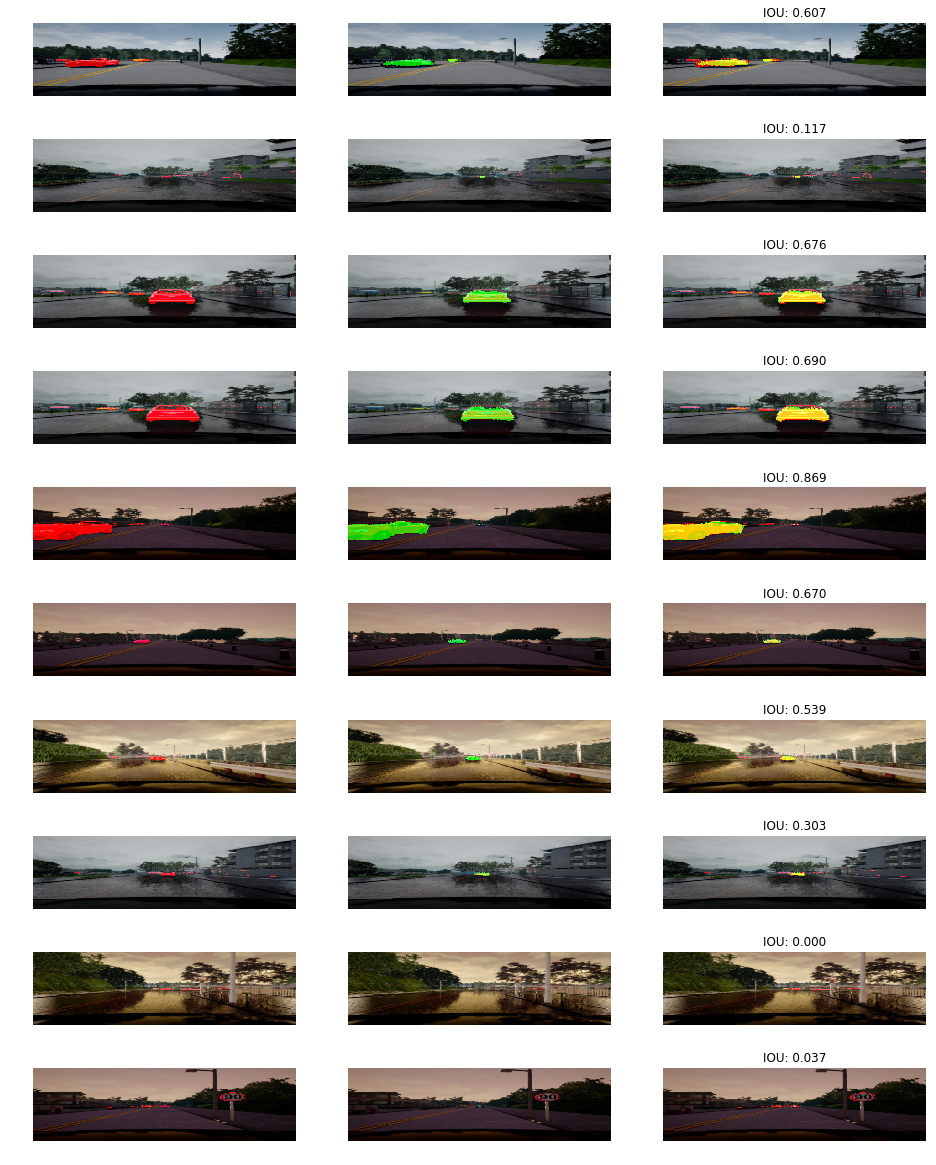

In [17]:
#Plot the best and worst
f, ax = plt.subplots(nrows=10, ncols=3)
f.set_size_inches(16, 21)
to_show = results[:5] + results[-5:]
for i, r in enumerate(to_show):
  # Generate red mask for ground truth
  print(np.array([[PIXEL_MAX * .8, 0, 0]])) 
  a = np.dot(r[2].reshape(160, -1, 1), np.array([[PIXEL_MAX * .8, 0, 0]]))
  # Generate green mask for predictions
  b = np.dot(r[1].reshape(160, -1, 1), np.array([[0, PIXEL_MAX * .8, 0]]))
  # Apply masks
  p = r[0][0] + a
  p[p > PIXEL_MAX] = PIXEL_MAX
  q = r[0][0] + b
  q[q > PIXEL_MAX] = PIXEL_MAX
  # Yellow shows intersection
  s = r[0][0] + a + b
  s[s > PIXEL_MAX] = PIXEL_MAX
  ax[i, 0].imshow(p.astype(np.uint8))
  ax[i, 1].imshow(q.astype(np.uint8))
  ax[i, 2].imshow(s.astype(np.uint8))
  ax[i, 2].set_title('IOU: {:.3f}'.format(r[3]))

 
  for j in range(3):
    ax[i, j].axis('off')
plt.show()

#### To find car and road on a single image; runs independently from here

In [1]:
import pickle
import numpy as np
import tensorflow as tf
import sys

# Third-party imports
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import scipy.misc

import imageio
import cv2

from tqdm import tqdm

PIXEL_MAX = 255

/anaconda/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


INFO:tensorflow:Restoring parameters from ./model_combined.ckpt


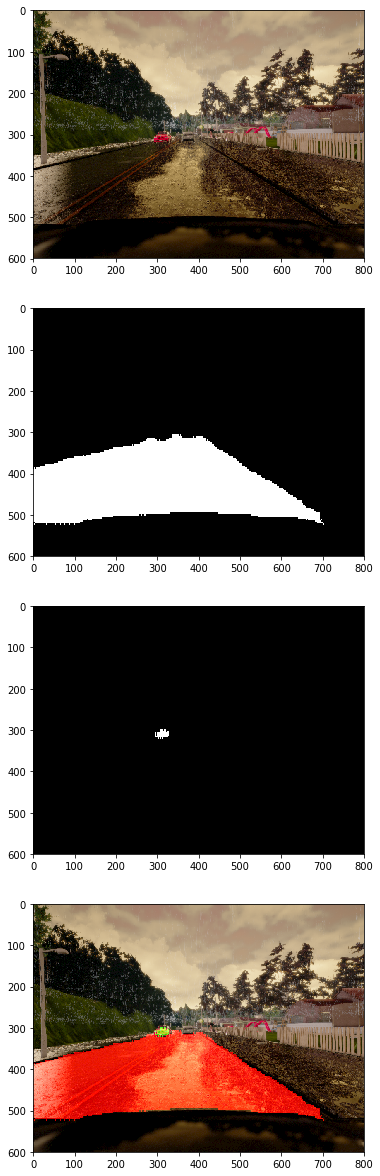

In [8]:
image_shape = (160, 576)

#loading testing data
testing = pickle.load( open("testing_data_pickle_both.p", "rb" ) )
loaded_graph = tf.Graph()
load_dir = './model_combined.ckpt'

fn = testing[80]
feature_image = imageio.imread(fn)
feature_copy = np.copy(feature_image)
#plt.imshow(feature_image)


feature_image = scipy.misc.imresize(feature_image, image_shape)
feature_image = feature_image.reshape(1,*feature_image.shape)

with tf.Session(graph=loaded_graph) as sess:
    #Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)
    
    # Gather required tensor references
    input_image = loaded_graph.get_tensor_by_name('image_input:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    predicted = loaded_graph.get_tensor_by_name('predicts:0')
    
    predicted = sess.run([predicted], feed_dict={input_image: feature_image,keep_prob: 1.0})
    predicted = predicted[0]
    
    binary_road_result = (predicted[:, 0] > .5).reshape(image_shape)
    binary_road_result = binary_road_result.astype('uint8')
    
    binary_car_result = (predicted[:, 1] > .5).reshape(image_shape)
    binary_car_result = binary_car_result.astype('uint8')
    
binary_car_result = scipy.misc.imresize(binary_car_result, (600,800))
binary_road_result = scipy.misc.imresize(binary_road_result, (600,800))

fig = plt.figure(figsize=(16,21))
plt.subplot(411)
plt.imshow(feature_copy)


plt.subplot(412)
plt.imshow(binary_road_result, cmap='gray')

plt.subplot(413)
plt.imshow(binary_car_result, cmap='gray')


# Generate red mask for where the road is
a = np.dot(binary_road_result.reshape(*binary_road_result.shape,1), np.array([[PIXEL_MAX * .8, 0, 0]]))
# Apply masks
p = feature_copy + a

# Generate green mask for where the car is
b = np.dot(binary_car_result.reshape(*binary_car_result.shape,1), np.array([[0, PIXEL_MAX * .8, 0]]))
# Apply masks
q = p + b


q[q > PIXEL_MAX] = PIXEL_MAX
plt.subplot(414)
plt.imshow(q.astype(np.uint8))


#### Check on video

In [4]:
import pickle
import numpy as np
import tensorflow as tf
import sys

# Third-party imports
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import scipy.misc

import imageio
import cv2

from tqdm import tqdm

from moviepy.editor import VideoFileClip
from IPython.display import HTML

PIXEL_MAX = 255

In [5]:
class MyVideoProcessor(object):
    def __init__(self,sess,input_image,keep_prob,predicted):
        self.sess = sess
        self.input_image=input_image
        self.keep_prob=keep_prob
        self.predicted=predicted
        
        self.image_shape = (160, 576)

        return
    def pipeline(self, rgb_frame):
        
        feature_copy = np.copy(rgb_frame)
        
        feature = scipy.misc.imresize(rgb_frame, self.image_shape)
        feature = feature.reshape(1,*feature.shape)
        
        result = self.sess.run([self.predicted], feed_dict={self.input_image: feature,self.keep_prob: 1.0})
        result=result[0]
        
        # Look for car :)
        binary_car_result = (result[:, 1] > .5).reshape(self.image_shape)
        binary_car_result = binary_car_result.astype('uint8')
        
        # Look for road :)
        binary_road_result = (result[:, 0] > .5).reshape(self.image_shape)
        binary_road_result = binary_road_result.astype('uint8')
        
        binary_car_result = scipy.misc.imresize(binary_car_result, (600,800))
        binary_road_result = scipy.misc.imresize(binary_road_result, (600,800))
        
        # Generate red mask for where the road is
        a = np.dot(binary_road_result.reshape(*binary_road_result.shape,1), np.array([[PIXEL_MAX * .8, 0, 0]]))
        # Apply masks
        p = feature_copy + a

        # Generate green mask for where the car is
        b = np.dot(binary_car_result.reshape(*binary_car_result.shape,1), np.array([[0, PIXEL_MAX * .8, 0]]))
        # Apply masks
        q = p + b


        q[q > PIXEL_MAX] = PIXEL_MAX
        q = q.astype(np.uint8)
        
        return q

In [6]:
loaded_graph = tf.Graph()
load_dir = './model_combined.ckpt'

with tf.Session(graph=loaded_graph) as sess:
    
    #Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)
    print("Model loaded")
    
    # Gather required tensor references
    input_image = loaded_graph.get_tensor_by_name('image_input:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    predicted = loaded_graph.get_tensor_by_name('predicts:0')
    
    my_video_processor_object = MyVideoProcessor(sess,input_image,keep_prob,predicted)
    project_video_output = 'test_video_output.mp4'
    clip = VideoFileClip("test_video.mp4")
    

    white_clip = clip.fl_image(my_video_processor_object.pipeline) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(project_video_output, audio=False)

INFO:tensorflow:Restoring parameters from ./model_combined.ckpt
Model loaded
[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 31/32 [01:03<00:01,  1.65s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 2min 30s, sys: 15.6 s, total: 2min 46s
Wall time: 1min 4s


In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))